# Accident Detection Model Training

This notebook trains a deep learning model to detect accidents from traffic camera images.

## Dataset Structure
- **Train**: Images for training the model
- **Validation**: Images for hyperparameter tuning
- **Test**: Images for final evaluation

Each split contains two classes:
- `Accident`: Images showing traffic accidents
- `Non Accident`: Normal traffic images

## 1. Import Required Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Scikit-learn for metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.20.0
GPU Available: []


## 2. Configure Paths and Hyperparameters

In [3]:
# Data paths
DATA_DIR = Path('data')
TRAIN_DIR = DATA_DIR / 'train'
VAL_DIR = DATA_DIR / 'val'
TEST_DIR = DATA_DIR / 'test'

# Model hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
CLASS_NAMES = ['Accident', 'Non Accident']

# Create models directory
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True)

print(f"Train Directory: {TRAIN_DIR}")
print(f"Validation Directory: {VAL_DIR}")
print(f"Test Directory: {TEST_DIR}")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")

Train Directory: data\train
Validation Directory: data\val
Test Directory: data\test
Image Size: (224, 224)
Batch Size: 32


## 3. Explore Dataset

In [4]:
# Count images in each split
def count_images(directory):
    counts = {}
    for class_name in CLASS_NAMES:
        class_path = directory / class_name
        if class_path.exists():
            counts[class_name] = len(list(class_path.glob('*.jpg'))) + len(list(class_path.glob('*.png')))
        else:
            counts[class_name] = 0
    return counts

train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VAL_DIR)
test_counts = count_images(TEST_DIR)

print("Dataset Distribution:")
print("="*50)
print(f"\nTrain Set:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(train_counts.values())} images")

print(f"\nValidation Set:")
for class_name, count in val_counts.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(val_counts.values())} images")

print(f"\nTest Set:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(test_counts.values())} images")

Dataset Distribution:

Train Set:
  Accident: 369 images
  Non Accident: 422 images
  Total: 791 images

Validation Set:
  Accident: 46 images
  Non Accident: 52 images
  Total: 98 images

Test Set:
  Accident: 47 images
  Non Accident: 53 images
  Total: 100 images


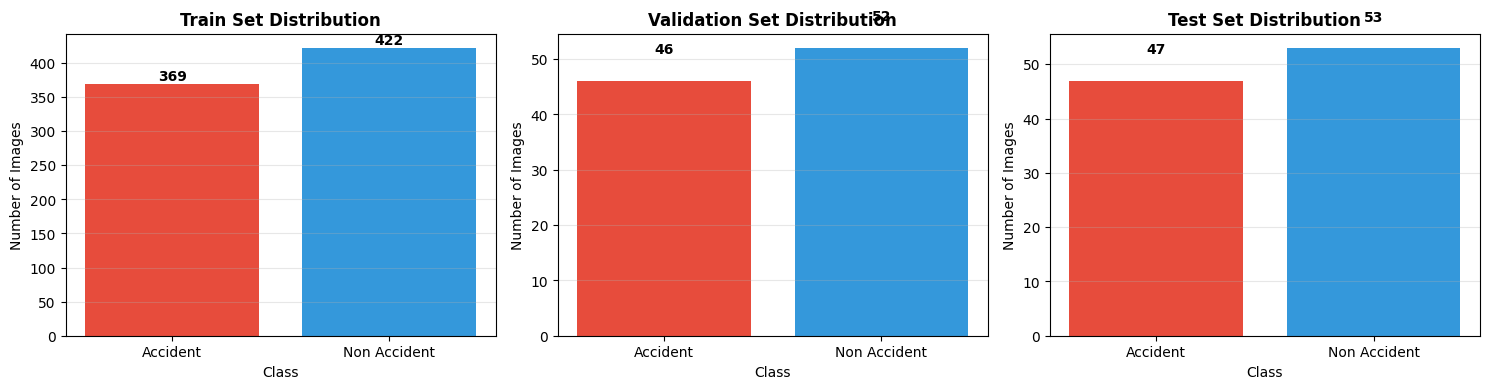

In [5]:
# Visualize dataset distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [('Train', train_counts), ('Validation', val_counts), ('Test', test_counts)]

for idx, (name, counts) in enumerate(datasets):
    axes[idx].bar(counts.keys(), counts.values(), color=['#e74c3c', '#3498db'])
    axes[idx].set_title(f'{name} Set Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].set_xlabel('Class')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (class_name, count) in enumerate(counts.items()):
        axes[idx].text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Visualize Sample Images

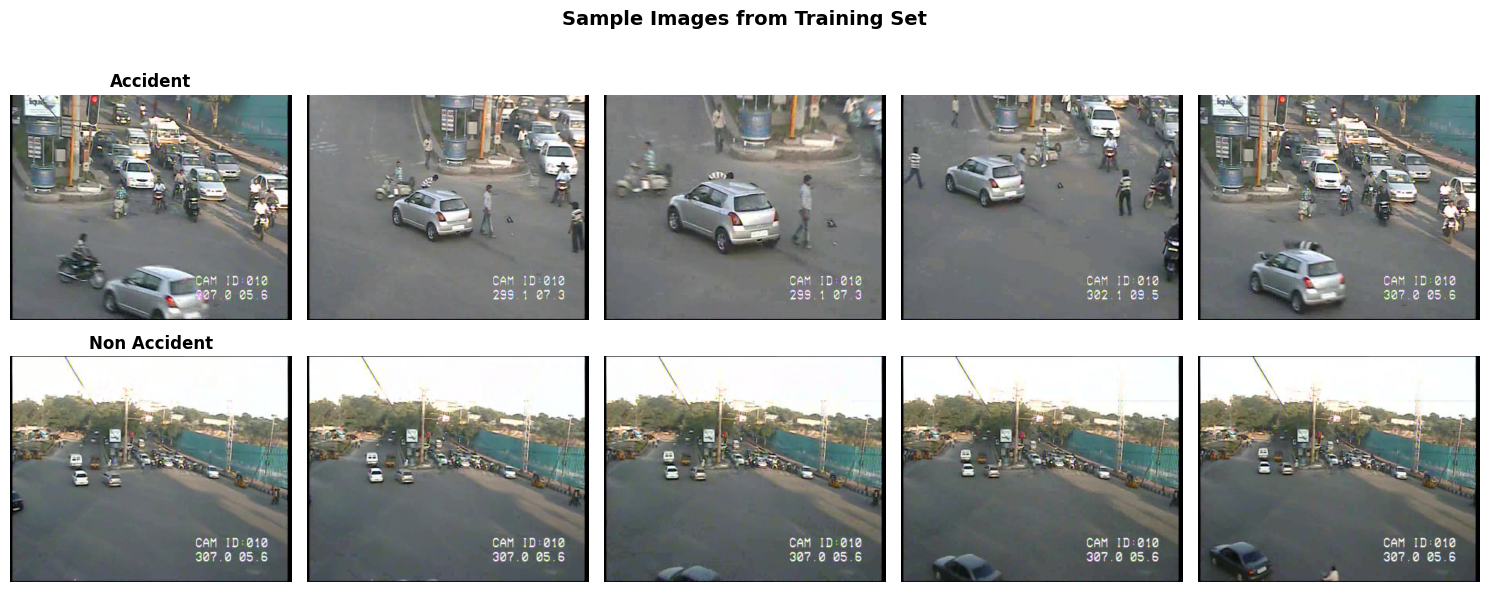

In [6]:
# Display sample images from each class
def display_samples(directory, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for idx, class_name in enumerate(CLASS_NAMES):
        class_path = directory / class_name
        image_files = list(class_path.glob('*.jpg'))[:num_samples]
        
        for i, img_path in enumerate(image_files):
            img = plt.imread(img_path)
            axes[idx, i].imshow(img)
            axes[idx, i].axis('off')
            if i == 0:
                axes[idx, i].set_title(f'{class_name}', fontsize=12, fontweight='bold')
    
    plt.suptitle('Sample Images from Training Set', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

display_samples(TRAIN_DIR)

## 5. Data Augmentation and Preprocessing

In [7]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescaling for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"\nClass Indices: {train_generator.class_indices}")
print(f"Total Training Batches: {len(train_generator)}")
print(f"Total Validation Batches: {len(val_generator)}")
print(f"Total Test Batches: {len(test_generator)}")

Found 791 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Found 100 images belonging to 2 classes.

Class Indices: {'Accident': 0, 'Non Accident': 1}
Total Training Batches: 25
Total Validation Batches: 4
Total Test Batches: 4


## 6. Build Model Architecture

We'll use transfer learning with MobileNetV2 as the base model for efficient and accurate accident detection.

In [8]:
def create_model(base_model_name='MobileNetV2', trainable_layers=20):
    """
    Create a transfer learning model for accident detection.
    
    Args:
        base_model_name: Name of the base model ('MobileNetV2', 'EfficientNetB0', 'ResNet50')
        trainable_layers: Number of layers to unfreeze for fine-tuning
    """
    # Load pre-trained base model
    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
    else:
        raise ValueError(f"Unknown base model: {base_model_name}")
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Build the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model, base_model

# Create the model
model, base_model = create_model('MobileNetV2')

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,089 (10.01 MB)

 Trainable params: 364,033 (1.39 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

## 7. Setup Training Callbacks

In [9]:
# Define callbacks
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        filepath=str(MODEL_DIR / 'best_accident_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured successfully!")

Callbacks configured successfully!


## 8. Train the Model (Initial Training)

In [10]:
# Train the model
print("Starting initial training with frozen base model...\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nInitial training completed!")

Starting initial training with frozen base model...

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5459 - loss: 0.9402 - precision: 0.5503 - recall: 0.8266
Epoch 1: val_accuracy improved from None to 0.61224, saving model to models\best_accident_model.h5



Epoch 1: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5714 - loss: 0.8650 - precision: 0.5735 - recall: 0.7678 - val_accuracy: 0.6122 - val_loss: 0.6099 - val_precision: 0.5854 - val_recall: 0.9231 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.6297 - loss: 0.7012 - precision: 0.6546 - recall: 0.6506
Epoch 2: val_accuracy improved from 0.61224 to 0.69388, saving model to models\best_accident_model.h5



Epoch 2: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 819ms/step - accuracy: 0.6435 - loss: 0.6858 - precision: 0.6691 - recall: 0.6564 - val_accuracy: 0.6939 - val_loss: 0.5548 - val_precision: 0.6486 - val_recall: 0.9231 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.6745 - loss: 0.6185 - precision: 0.7029 - recall: 0.7057
Epoch 3: val_accuracy improved from 0.69388 to 0.72449, saving model to models\best_accident_model.h5



Epoch 3: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 891ms/step - accuracy: 0.6802 - loss: 0.6155 - precision: 0.6882 - recall: 0.7322 - val_accuracy: 0.7245 - val_loss: 0.5148 - val_precision: 0.6812 - val_recall: 0.9038 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.7257 - loss: 0.5632 - precision: 0.7250 - recall: 0.7664
Epoch 4: val_accuracy improved from 0.72449 to 0.74490, saving model to models\best_accident_model.h5



Epoch 4: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 971ms/step - accuracy: 0.7244 - loss: 0.5625 - precision: 0.7440 - recall: 0.7370 - val_accuracy: 0.7449 - val_loss: 0.4803 - val_precision: 0.7288 - val_recall: 0.8269 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.6745 - loss: 0.5904 - precision: 0.6758 - recall: 0.7196
Epoch 5: val_accuracy improved from 0.74490 to 0.75510, saving model to models\best_accident_model.h5



Epoch 5: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 906ms/step - accuracy: 0.6928 - loss: 0.5906 - precision: 0.7011 - recall: 0.7393 - val_accuracy: 0.7551 - val_loss: 0.4445 - val_precision: 0.7593 - val_recall: 0.7885 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.7391 - loss: 0.5258 - precision: 0.7598 - recall: 0.7869
Epoch 6: val_accuracy improved from 0.75510 to 0.77551, saving model to models\best_accident_model.h5



Epoch 6: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 863ms/step - accuracy: 0.7206 - loss: 0.5559 - precision: 0.7219 - recall: 0.7749 - val_accuracy: 0.7755 - val_loss: 0.4412 - val_precision: 0.8125 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.7482 - loss: 0.5022 - precision: 0.7502 - recall: 0.7774
Epoch 7: val_accuracy improved from 0.77551 to 0.81633, saving model to models\best_accident_model.h5



Epoch 7: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 892ms/step - accuracy: 0.7219 - loss: 0.5302 - precision: 0.7360 - recall: 0.7464 - val_accuracy: 0.8163 - val_loss: 0.4182 - val_precision: 0.8036 - val_recall: 0.8654 - learning_rate: 0.0010
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.8022 - loss: 0.4296 - precision: 0.8161 - recall: 0.8233
Epoch 8: val_accuracy improved from 0.81633 to 0.84694, saving model to models\best_accident_model.h5



Epoch 8: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 886ms/step - accuracy: 0.7649 - loss: 0.4821 - precision: 0.7706 - recall: 0.7962 - val_accuracy: 0.8469 - val_loss: 0.3864 - val_precision: 0.8246 - val_recall: 0.9038 - learning_rate: 0.0010
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.7235 - loss: 0.5279 - precision: 0.7249 - recall: 0.7714
Epoch 9: val_accuracy did not improve from 0.84694
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 883ms/step - accuracy: 0.7358 - loss: 0.5078 - precision: 0.7448 - recall: 0.7678 - val_accuracy: 0.8469 - val_loss: 0.3651 - val_precision: 0.8033 - val_recall: 0.9423 - learning_rate: 0.0010
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.7765 - loss: 0.4775 - precision: 0.7953 - recall: 0.7868
Epoch 10: val_accuracy did not improve from 0.84694
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 972ms/step - accuracy: 0.7623 - loss: 0.4827 - precision: 0.7696 - recall: 0.7915 - val_accuracy: 0.8469 -


Epoch 11: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 892ms/step - accuracy: 0.7573 - loss: 0.5238 - precision: 0.7700 - recall: 0.7773 - val_accuracy: 0.8776 - val_loss: 0.3296 - val_precision: 0.8846 - val_recall: 0.8846 - learning_rate: 0.0010
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.7581 - loss: 0.5088 - precision: 0.7563 - recall: 0.8070
Epoch 12: val_accuracy did not improve from 0.87755
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 862ms/step - accuracy: 0.7649 - loss: 0.4867 - precision: 0.7622 - recall: 0.8128 - val_accuracy: 0.8776 - val_loss: 0.3179 - val_precision: 0.8704 - val_recall: 0.9038 - learning_rate: 0.0010
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.7698 - loss: 0.4921 - precision: 0.7651 - recall: 0.8112
Epoch 13: val_accuracy improved from 0.87755 to 0.89796, saving model to models\best_accident_model.h5



Epoch 13: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 991ms/step - accuracy: 0.7623 - loss: 0.4955 - precision: 0.7647 - recall: 0.8009 - val_accuracy: 0.8980 - val_loss: 0.3191 - val_precision: 0.8621 - val_recall: 0.9615 - learning_rate: 0.0010
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.7602 - loss: 0.4875 - precision: 0.7409 - recall: 0.8516
Epoch 14: val_accuracy did not improve from 0.89796
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 921ms/step - accuracy: 0.7611 - loss: 0.4678 - precision: 0.7572 - recall: 0.8128 - val_accuracy: 0.8673 - val_loss: 0.3154 - val_precision: 0.8545 - val_recall: 0.9038 - learning_rate: 0.0010
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.7500 - loss: 0.5058 - precision: 0.7721 - recall: 0.7733
Epoch 15: val_accuracy did not improve from 0.89796
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 926ms/step - accuracy: 0.7724 - loss: 0.4932 - precision: 0.7750 - recall: 0.8081 - val_accuracy: 0.867


Epoch 17: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 857ms/step - accuracy: 0.7623 - loss: 0.4652 - precision: 0.7734 - recall: 0.7844 - val_accuracy: 0.9286 - val_loss: 0.2772 - val_precision: 0.9091 - val_recall: 0.9615 - learning_rate: 0.0010
Epoch 18/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.8227 - loss: 0.3980 - precision: 0.8153 - recall: 0.8553
Epoch 18: val_accuracy did not improve from 0.92857
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 837ms/step - accuracy: 0.8066 - loss: 0.4170 - precision: 0.8022 - recall: 0.8460 - val_accuracy: 0.9082 - val_loss: 0.2785 - val_precision: 0.8525 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 19/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.7494 - loss: 0.4740 - precision: 0.7404 - recall: 0.8370
Epoch 19: val_accuracy did not improve from 0.92857
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 848ms/step - accuracy: 0.7699 - loss: 0.4583 - precision: 0.7632 - recall: 0.8246 - val_accuracy: 0.928


Epoch 31: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7927 - loss: 0.4329 - precision: 0.7945 - recall: 0.8246 - val_accuracy: 0.9388 - val_loss: 0.2394 - val_precision: 0.9107 - val_recall: 0.9808 - learning_rate: 0.0010
Epoch 32/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8160 - loss: 0.4083 - precision: 0.8199 - recall: 0.8477 
Epoch 32: val_accuracy did not improve from 0.93878
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8255 - loss: 0.3866 - precision: 0.8257 - recall: 0.8531 - val_accuracy: 0.9388 - val_loss: 0.2372 - val_precision: 0.9107 - val_recall: 0.9808 - learning_rate: 5.0000e-04
Epoch 33/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.8284 - loss: 0.3752 - precision: 0.8290 - recall: 0.8581
Epoch 33: val_accuracy did not improve from 0.93878
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8217 - loss: 0.3824 - precision: 0.8172 - recall: 0.8578 - val_accuracy: 0.9184 - val


Epoch 37: finished saving model to models\best_accident_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8015 - loss: 0.3939 - precision: 0.8089 - recall: 0.8223 - val_accuracy: 0.9694 - val_loss: 0.2155 - val_precision: 0.9623 - val_recall: 0.9808 - learning_rate: 5.0000e-04
Epoch 38/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8579 - loss: 0.3597 - precision: 0.8416 - recall: 0.9146
Epoch 38: val_accuracy did not improve from 0.96939
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8546 - loss: 0.3568 - precision: 0.8301 - recall: 0.9147 - val_accuracy: 0.9694 - val_loss: 0.2089 - val_precision: 0.9623 - val_recall: 0.9808 - learning_rate: 5.0000e-04
Epoch 39/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.8367 - loss: 0.3667 - precision: 0.8329 - recall: 0.8514
Epoch 39: val_accuracy did not improve from 0.96939
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8230 - loss: 0.3898 - precision: 0.8279 - recall: 0.8436 - val_accuracy: 0.9490 - 

## 9. Fine-Tuning (Unfreeze Some Layers)

In [14]:
# Unfreeze the last layers of the base model for fine-tuning
base_model.trainable = True

# Freeze all layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print(f"Fine-tuning with {sum([1 for layer in base_model.layers if layer.trainable])} trainable layers")

# Continue training with fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nFine-tuning completed!")

Fine-tuning with 20 trainable layers
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8789 - loss: 0.2715 - precision_2: 0.8348 - recall_2: 0.9442
Epoch 1: val_accuracy did not improve from 0.96939
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8812 - loss: 0.2808 - precision_2: 0.8677 - recall_2: 0.9171 - val_accuracy: 0.9388 - val_loss: 0.1712 - val_precision_2: 0.9423 - val_recall_2: 0.9423 - learning_rate: 1.0000e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8816 - loss: 0.2825 - precision_2: 0.8712 - recall_2: 0.9086
Epoch 2: val_accuracy did not improve from 0.96939
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8963 - loss: 0.2404 - precision_2: 0.8917 - recall_2: 0.9171 - val_accuracy: 0.9184 - val_loss: 0.1924 - val_precision_2: 0.9583 - val_recall_2: 0.8846 - learning_rate: 1.0000e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8933 - loss: 0.2753 - precision_2: 0.8818 - recall_2: 0.9198
Epoch 3: val_accuracy d

## 10. Visualize Training History

In [15]:
def plot_training_history(history, history_fine=None):
    """
    Plot training and validation metrics over epochs.
    """
    # Combine histories if fine-tuning was performed
    if history_fine:
        for key in history.history.keys():
            history.history[key].extend(history_fine.history[key])
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history, history_fine)

KeyError: 'precision'

## 11. Evaluate on Test Set

In [ ]:
# Evaluate on test set
print("Evaluating model on test set...\n")

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

# Calculate F1 Score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print("="*50)

## 12. Generate Predictions and Confusion Matrix

In [ ]:
# Get predictions
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

print(f"\nPredictions shape: {y_pred.shape}")
print(f"True labels shape: {y_true.shape}")

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Accident Detection', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)

## 13. Classification Report

In [ ]:
# Detailed classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

## 14. ROC Curve and AUC

In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Accident Detection Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nArea Under ROC Curve (AUC): {roc_auc:.4f}")

## 15. Visualize Predictions on Test Images

In [ ]:
# Visualize predictions on random test images
def visualize_predictions(generator, model, num_images=12):
    """
    Display predictions on random test images.
    """
    generator.reset()
    x_batch, y_batch = next(generator)
    predictions = model.predict(x_batch[:num_images])
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for i in range(num_images):
        axes[i].imshow(x_batch[i])
        
        true_label = CLASS_NAMES[int(y_batch[i])]
        pred_label = CLASS_NAMES[int(predictions[i] > 0.5)]
        confidence = predictions[i][0] if predictions[i] > 0.5 else 1 - predictions[i][0]
        
        color = 'green' if true_label == pred_label else 'red'
        
        axes[i].set_title(
            f'True: {true_label}\nPred: {pred_label} ({confidence:.2%})',
            color=color,
            fontsize=10,
            fontweight='bold'
        )
        axes[i].axis('off')
    
    plt.suptitle('Model Predictions on Test Images', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

visualize_predictions(test_generator, model)

## 16. Save the Final Model

In [ ]:
# Save the complete model
model_path = MODEL_DIR / 'accident_detection_model_final.h5'
model.save(model_path)
print(f"Model saved to: {model_path}")

# Save model in TensorFlow SavedModel format (for deployment)
saved_model_path = MODEL_DIR / 'accident_detection_saved_model'
model.save(saved_model_path, save_format='tf')
print(f"SavedModel format saved to: {saved_model_path}")

# Save model weights only
weights_path = MODEL_DIR / 'accident_detection_weights.h5'
model.save_weights(weights_path)
print(f"Model weights saved to: {weights_path}")

## 17. Model Summary and Performance Metrics

In [ ]:
# Create a summary DataFrame
summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    'Score': [test_accuracy, test_precision, test_recall, test_f1, roc_auc]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Score (%)'] = summary_df['Score'] * 100

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)

# Visualize metrics
plt.figure(figsize=(10, 6))
bars = plt.bar(summary_df['Metric'], summary_df['Score'], 
               color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'])
plt.ylim([0, 1.1])
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 18. Load and Test Saved Model

In [ ]:
# Load the saved model to verify it works
loaded_model = keras.models.load_model(model_path)
print("Model loaded successfully!\n")

# Test the loaded model
test_generator.reset()
loaded_test_loss, loaded_test_accuracy, loaded_test_precision, loaded_test_recall = loaded_model.evaluate(
    test_generator, verbose=0
)

print("Loaded Model Test Results:")
print(f"  Accuracy: {loaded_test_accuracy:.4f}")
print(f"  Precision: {loaded_test_precision:.4f}")
print(f"  Recall: {loaded_test_recall:.4f}")
print("\n✓ Model saved and loaded successfully!")

## 19. Inference Function for New Images

In [ ]:
def predict_accident(image_path, model, threshold=0.5):
    """
    Predict whether an image contains an accident.
    
    Args:
        image_path: Path to the image file
        model: Trained Keras model
        threshold: Classification threshold (default: 0.5)
    
    Returns:
        prediction: Class label ('Accident' or 'Non Accident')
        confidence: Prediction confidence score
    """
    # Load and preprocess image
    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Make prediction
    prediction_prob = model.predict(img_array, verbose=0)[0][0]
    
    if prediction_prob > threshold:
        prediction = 'Non Accident'
        confidence = prediction_prob
    else:
        prediction = 'Accident'
        confidence = 1 - prediction_prob
    
    return prediction, confidence

# Example usage
print("Inference function created successfully!")
print("\nUsage example:")
print("  prediction, confidence = predict_accident('path/to/image.jpg', model)")
print("  print(f'Prediction: {prediction} (Confidence: {confidence:.2%})')")

## 20. Test Inference on Sample Images

In [ ]:
# Test inference on a few sample images
sample_images = []

# Get sample images from test set
for class_name in CLASS_NAMES:
    class_path = TEST_DIR / class_name
    images = list(class_path.glob('*.jpg'))[:2]
    sample_images.extend(images)

# Display predictions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, img_path in enumerate(sample_images[:4]):
    # Make prediction
    prediction, confidence = predict_accident(str(img_path), model)
    
    # Display image
    img = plt.imread(img_path)
    axes[i].imshow(img)
    
    # Get true label from path
    true_label = img_path.parent.name
    
    # Set title color based on correctness
    color = 'green' if prediction == true_label else 'red'
    
    axes[i].set_title(
        f'True: {true_label}\nPredicted: {prediction}\nConfidence: {confidence:.2%}',
        color=color,
        fontsize=11,
        fontweight='bold'
    )
    axes[i].axis('off')

plt.suptitle('Inference Test on Sample Images', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 21. Model Export Summary

In [ ]:
print("\n" + "="*70)
print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)

print("\n📊 Final Performance:")
print(f"   • Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   • Test Precision: {test_precision:.4f}")
print(f"   • Test Recall: {test_recall:.4f}")
print(f"   • Test F1-Score: {test_f1:.4f}")
print(f"   • AUC-ROC: {roc_auc:.4f}")

print("\n💾 Saved Models:")
print(f"   • Full Model (H5): {model_path}")
print(f"   • SavedModel Format: {saved_model_path}")
print(f"   • Model Weights: {weights_path}")
print(f"   • Best Model (Checkpoint): {MODEL_DIR / 'best_accident_model.h5'}")

print("\n🎯 Model Details:")
print(f"   • Architecture: Transfer Learning with MobileNetV2")
print(f"   • Input Size: {IMG_SIZE}")
print(f"   • Classes: {CLASS_NAMES}")
print(f"   • Total Parameters: {model.count_params():,}")

print("\n✅ Ready for deployment!")
print("="*70)